In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
import matplotlib.pyplot as plt
import numpy as np
# %pylab inline
from tqdm.auto import tqdm

# Edge counting

This demo shows how you can use QICK in a special "edge-counting" mode, where instead of integrating the I/Q values inside a readout window, QICK counts the number of rising edges inside the window. This functionality was developed by the [QICK-DAWG](https://github.com/sandialabs/qick-dawg) team for photon counting, but can also be used for counting RF pulses.

Edge counting requires your firmware to have a recent version of `axis_avg_buffer` (the buffer that stores decimated and accumulated data), as indicated by the "has edge counter" text in the firmware configuration's description of the readout channel.

In [2]:
soc = QickSoc()
soccfg = soc
print(soccfg)

QICK running on RFSoC4x2, software version 0.2.381

Firmware configuration (built Mon Dec 15 20:44:36 2025):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 491.520
	Groups of related clocks: [tProc clock, DAC tile 0, DAC tile 2], [ADC tile 0]

	DAC output power mode: 20mA

	2 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 Msps, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		axis_avg_buffer v1.2 (has edge counter, no weights)
		memory 16384 accumulated, 4096 decimated (7.407 us)
		triggered by output 7, pin 14, feedback to tProc input 0
		ADC tile 0, blk 

## Testing the counter with a readout-only program

Let's start with a simple program that doesn't play pulses, it just runs a readout in edge-counting mode.

Note that we disable downconversion in the readout using `sel='input'` and `freq=0`. This is what you want if you're counting DC-coupled pulses from a photodiode or similar. However, the edge counter will also work on downconverted RF pulses - it will just look at the I component of the signal.

For DC-coupled pulses, you will also want to use an ADC with a DC-coupled amplifier instead of a balun (see [QICK-DAWG](https://github.com/sandialabs/qick-dawg) for information on setting up a RFSoC4x2 in this configuration). However, I am running this demo with an unmodified RFSoC4x2 (which is fine, because I'm not looking at real pulses).

In [3]:
class ReadoutProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        
        self.declare_readout(ch=self.cfg['ro_ch'], length=self.cfg['readout_length'], freq=0,
                             sel='input',
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

In [4]:
def find_edges(samples, thresh_h, thresh_l):
    """Emulate the edge-counting algorithm on decimated data.
    """
    edges = []
    h_state = False
    for i, sample in enumerate(samples):
        last_state = h_state
        if sample > thresh_h:
            h_state = True
        elif sample < thresh_l:
            h_state = False
        if i > 0 and h_state and not last_state:
            edges.append(i)
    return edges

def plot_edges(samples, thresh_h, thresh_l):
    # plot the decimated data
    plt.plot(samples)
    plt.ylabel("a.u.")
    plt.xlabel("Clock ticks")

    # show the thresholds
    plt.axhline(config['high_threshold']+0.5, color='purple')
    plt.axhline(config['low_threshold']-0.5, color='purple')

    # run the software edge-counter on the decimated data
    edges = find_edges(samples, thresh_h, thresh_l)
    # highlight the edges found by the software
    if len(edges)>0: plt.scatter(edges, samples[edges], c='red');
    return edges

The edge counter implements a Schmitt trigger: it compares the input signal (the I component of the decimated data) to a low and a high threshold, and only counts edges if the signal goes from below the low threshold to above the high threshold.

Let's test the edge counter by comparing the counter output to the decimated trace. The edge counter agrees with what we get by counting edges in software using the `find_edges()` code above.

Here we're just looking at noise, but if you have a pulse generator or photon detector you could look at that. In either case you may need to adjust the thresholds and readout length as appropriate for your setup.

  0%|          | 0/1 [00:00<?, ?it/s]

firmware count=8, software count=8


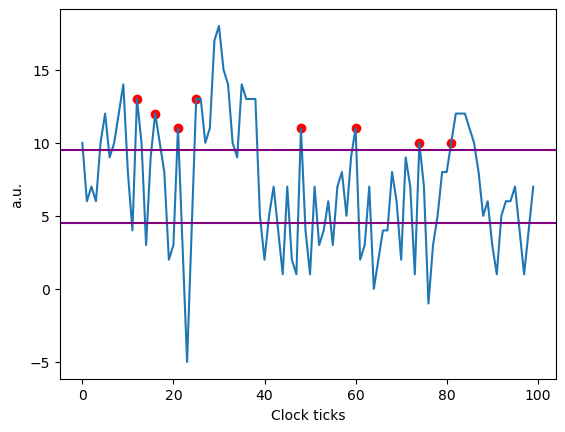

In [5]:
config={"ro_ch": 0,
        "reps": 1,
        "relax_delay":10, # --us        
        "readout_length":100, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "high_threshold": 2,
        "low_threshold": -2,
        "soft_avgs":1
       }

# we'll set the thresholds relative to the mean value of the ADC, to account for any offset
prog =ReadoutProgram(soccfg, config)
avg = prog.acquire_decimated(soc)[0].mean(axis=1)[0]
config['high_threshold'] = int(avg)+2
config['low_threshold'] = int(avg)-2

prog =ReadoutProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)

samples = iq_list[0][0]
counts = prog.get_raw()[0][0,0,0]

edges = plot_edges(samples, config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

Counting edges in noise is a nice stress test of the edge-counter; let's run it 1000 times and check that it always agrees.

Older versions of the edge counter will occasionally find an extra edge.

  0%|          | 0/1000 [00:00<?, ?it/s]

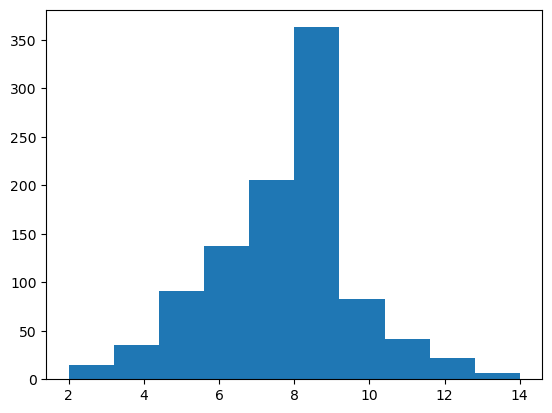

In [6]:
allcounts = []
for i in tqdm(range(1000)):
    iq_list = prog.acquire_decimated(soc, progress=False)

    samples = iq_list[0][0]
    counts = prog.get_raw()[0][0,0,0]
    allcounts.append(counts)

    if counts != len(find_edges(samples, config['high_threshold'], config['low_threshold'])):
        edges = plot_edges(samples, config['high_threshold'], config['low_threshold'])
        print("firmware count=%d, software count=%d"%(counts, len(edges)))
        break
plt.hist(allcounts);

Now let's make the readout window longer (100 us) and do 1000 reps.

Similarly to standard readout, you can get the average result from the output of `acquire()` or use `get_raw()` to get shot-by-shot results. Note that unlike standard readout, the output of `acquire()` is not normalized to the window length (the result is in counts, not counts-per-tick, whereas for normal readout the result is ADU-per-tick).

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=4168.712


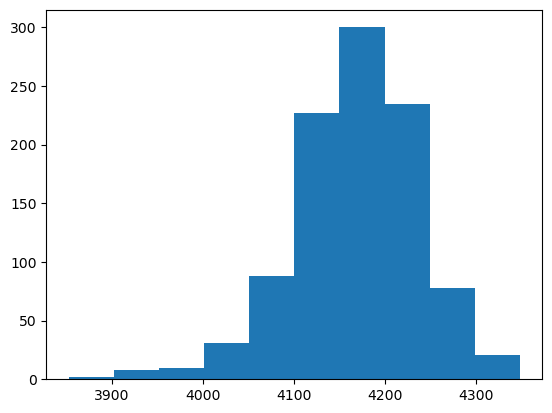

In [7]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =ReadoutProgram(soccfg, config)

iq_list = prog.acquire(soc)
mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]

plt.hist(counts);

## Counting pulses in loopback
Now let's play pulses in loopback, and count them.

We're going to configure the generator in periodic mode, where it plays the defined pulse repeatedly without gaps.
We can just send that command once during the initialization block of our program, and the generator will play the pulse forever until we tell it to do something else.

In [8]:
class LoopbackProgramDC(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_readout(ch=cfg['ro_ch'], length=cfg['readout_length'], freq=0,
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )

        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=1)
        
        # define a pulse envelope that's high for pulse_length, and 0 the rest of the time
        idata = np.zeros(16*self.us2cycles(cfg['pulse_period'], gen_ch=gen_ch))
        idata[:16*self.us2cycles(cfg['pulse_length'], gen_ch=gen_ch)] = 2**15-2
        self.add_pulse(ch=gen_ch, name="pulse", idata=idata)
        
        # tell the generator to play this pulse repeatedly forever
        self.set_pulse_registers(ch=gen_ch, style="arb", freq=0, phase=0, gain=10000, 
                                     waveform="pulse", mode="periodic")
        self.pulse(ch=gen_ch, t=0)

        self.synci(200)  # give processor some time to configure pulses
   
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

Observe how the baluns distort the pulse shape (baluns block DC, which is roughly equivalent to differentiating the pulse). But we're able to count the rising edges.

firmware count=1, software count=1


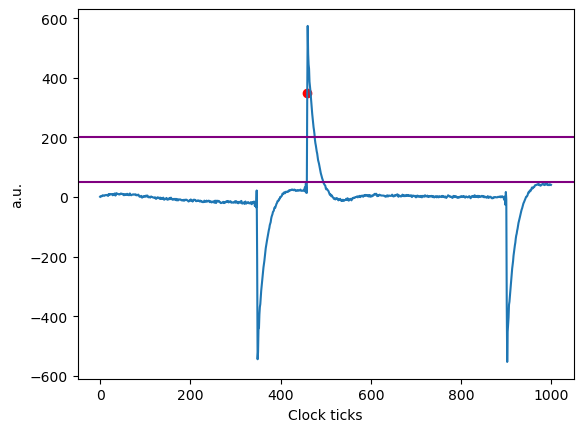

In [9]:
config={"ro_ch": 0,
        "gen_ch": 0,
        "reps": 1,
        "relax_delay": 10, # --us
        "pulse_period": 1, # --us
        "pulse_length": 0.2, # --us
        "readout_length":1000, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "high_threshold": 200,
        "low_threshold": 50,
        "soft_avgs":1
       }

prog =LoopbackProgramDC(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

samples = iq_list[0][0]
counts = prog.get_raw()[0][0,0,0]

edges = plot_edges(samples, config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

Again, we can check the firmware counting algorithm against our software emulation.

Note that because the periodic pulse is playing periodically and its period is different from the readout window duration and the delay between readouts, the number of edges per readout varies. Useful for a test.

  0%|          | 0/100 [00:00<?, ?it/s]

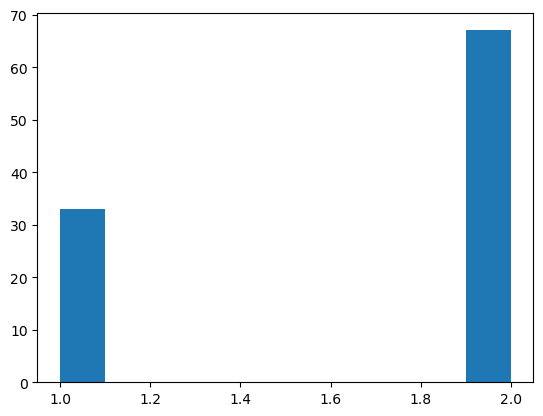

In [10]:
allcounts = []
for i in tqdm(range(100)):
    iq_list = prog.acquire_decimated(soc, progress=False)

    samples = iq_list[0][0]
    counts = prog.get_raw()[0][0,0,0]
    allcounts.append(counts)

    if counts != len(find_edges(samples, config['high_threshold'], config['low_threshold'])):
        edges = plot_edges(samples, config['high_threshold'], config['low_threshold'])
        print("firmware count=%d, software count=%d"%(counts, len(edges)))
        break
soc.reset_gens()        
plt.hist(allcounts);

If we again run longer readouts, we can see that we get 100 pulses in our 100-us window (and sometimes 101, because the readout window is very slightly wider than the pulse period due to rounding). Good.

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=100.063


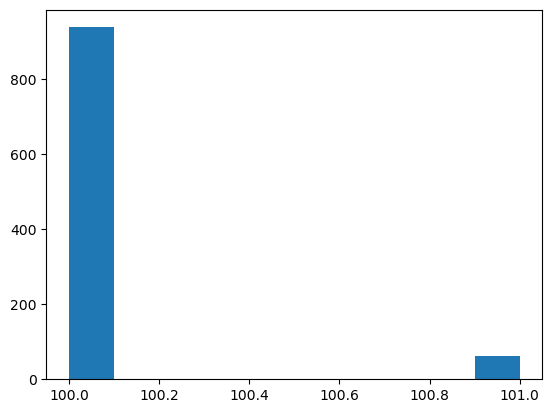

In [11]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =LoopbackProgramDC(soccfg, config)

iq_list = prog.acquire(soc)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]
plt.hist(counts);

Let's repeat with RF pulses.

In [12]:
class LoopbackProgramRF(AveragerProgram):
    def initialize(self):
        cfg=self.cfg
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_readout(ch=cfg['ro_ch'], length=cfg['readout_length'], freq=cfg['freq'],
                             gen_ch=gen_ch,
                             phase=cfg['ro_phase'],
                             edge_counting=True,
                             high_threshold=cfg['high_threshold'],
                             low_threshold=cfg['low_threshold'],
                            )
        
        self.declare_gen(ch=gen_ch, nqz=1)
        gen_freq = self.freq2reg(cfg['freq'], gen_ch=gen_ch, ro_ch=ro_ch)
        
        # define a pulse envelope that's high for pulse_length, and 0 the rest of the time
        idata = np.zeros(16*self.us2cycles(cfg['pulse_period'], gen_ch=gen_ch))
        idata[:16*self.us2cycles(cfg['pulse_length'], gen_ch=gen_ch)] = 2**15-2
        self.add_pulse(ch=gen_ch, name="pulse", idata=idata)
        
        # tell the generator to play this pulse repeatedly forever
        self.set_pulse_registers(ch=gen_ch, style="arb", freq=gen_freq, phase=0, gain=10000, 
                                     waveform="pulse", mode="periodic")
        self.pulse(ch=gen_ch, t=0)

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.trigger(adcs=[self.cfg['ro_ch']], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg['relax_delay']))

Since the edge counter looks at the I component, we want to rotate the readout phase to put our signal on the I axis.

changing readout phase to -43.04 degrees


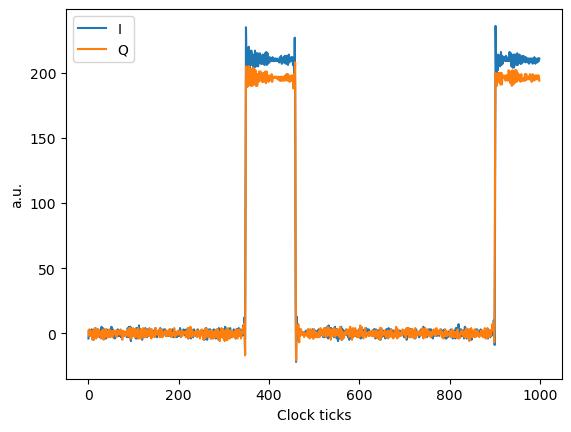

In [13]:
config={"ro_ch": 0,
        "gen_ch": 0,
        "reps": 1,
        "relax_delay": 10, # --us
        "pulse_period": 1, # --us
        "pulse_length": 0.2, # --us
        "readout_length":1000, # [RO clock ticks]
        "adc_trig_offset": 100, # [tProc clock ticks]
        "freq": 200,
        "ro_phase": 0, # degrees
        "high_threshold": 100,
        "low_threshold": 10,
        "soft_avgs":1
       }

prog =LoopbackProgramRF(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

plt.plot(iq_list[0][0], label='I')
plt.plot(iq_list[0][1], label='Q')
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.legend()

# compute the IQ angle in the decimated data, and set the readout phase to bring that to 0 in the next run
config['ro_phase'] = -np.angle(np.mean(iq_list[0][0] + 1j*iq_list[0][1]), deg=True)
print("changing readout phase to %.2f degrees" % (config['ro_phase']))

Now we can look at the counts, which look good.

firmware count=2, software count=2


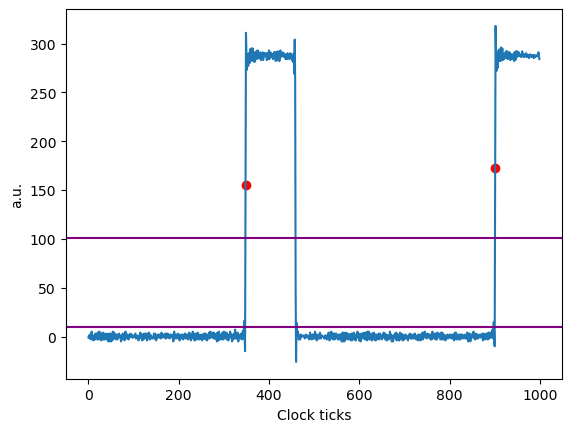

In [14]:
prog =LoopbackProgramRF(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=False)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

counts = prog.get_raw()[0][0,0,0]

edges = plot_edges(iq_list[0][0], config['high_threshold'], config['low_threshold'])
print("firmware count=%d, software count=%d"%(counts, len(edges)))

  0%|          | 0/1000 [00:00<?, ?it/s]

average count=100.064


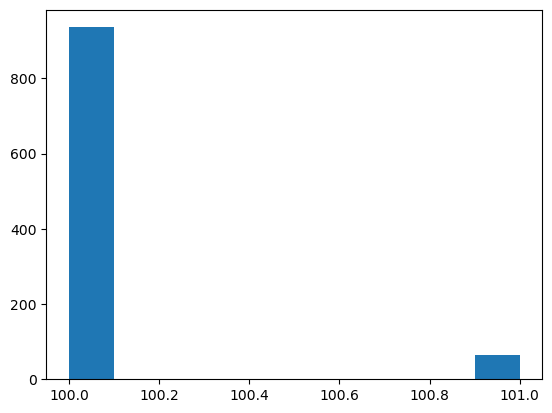

In [15]:
config['reps'] = 1000
config['readout_length'] = soccfg.us2cycles(100, ro_ch=config['ro_ch'])
prog =LoopbackProgramRF(soccfg, config)

iq_list = prog.acquire(soc)
# stop the periodic pulsing, because otherwise it will continue forever
soc.reset_gens()

mean_counts = iq_list[0][0][0]
print("average count=%.3f"%(mean_counts))

counts = prog.get_raw()[0][:,0,0]
plt.hist(counts);